In [2]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('../../Boston_housing_dataset/HousingData.csv')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [5]:
df.isna().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

# ***imputing missing values*** using  [IterativeImputer + RandomForestRegressor]

In [6]:

# Define the imputer
imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=10, random_state=0),
    max_iter=20,
    random_state=0
)

# Fit and transform
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

print(df_imputed.head())


      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90  4.980  24.0  
1     17.8  396.90  9.140  21.6  
2     17.8  392.83  4.030  34.7  
3     18.7  394.63  2.940  33.4  
4     18.7  396.90  4.527  36.2  


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [7]:
#check again 
df_imputed.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [8]:
df = df_imputed

***Feature correlation / korelasi antar fitur***

<Axes: >

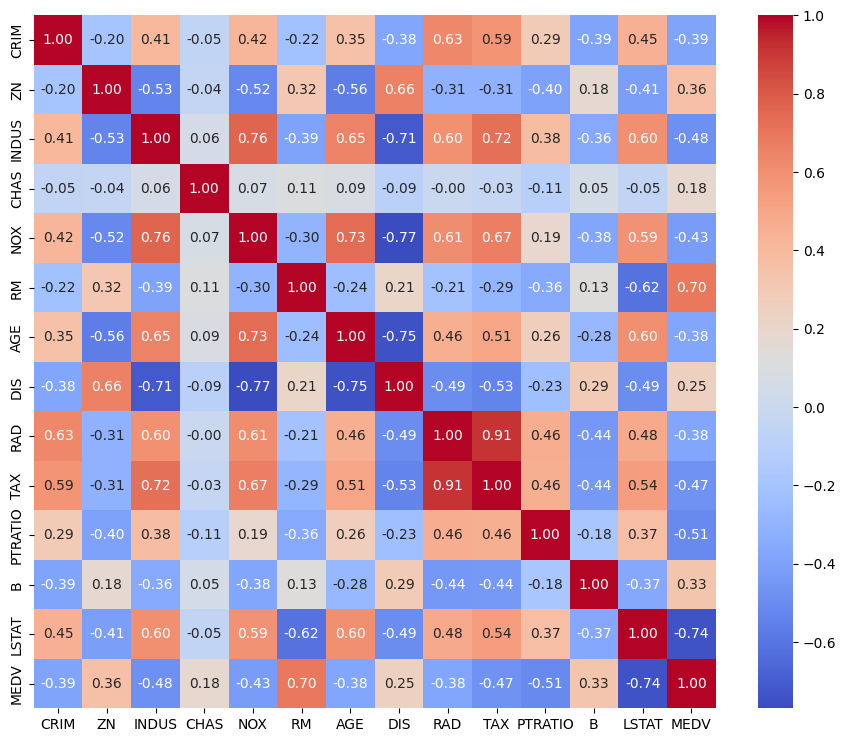

In [15]:
corr = df.corr()
plt.figure(figsize=(11, 9))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')


# feature selection using **SHAP**

PermutationExplainer explainer: 103it [08:13,  4.94s/it]                         
C:\Users\USER\AppData\Local\Temp\ipykernel_19408\3710431132.py:30: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_test, feature_names=feature_names)


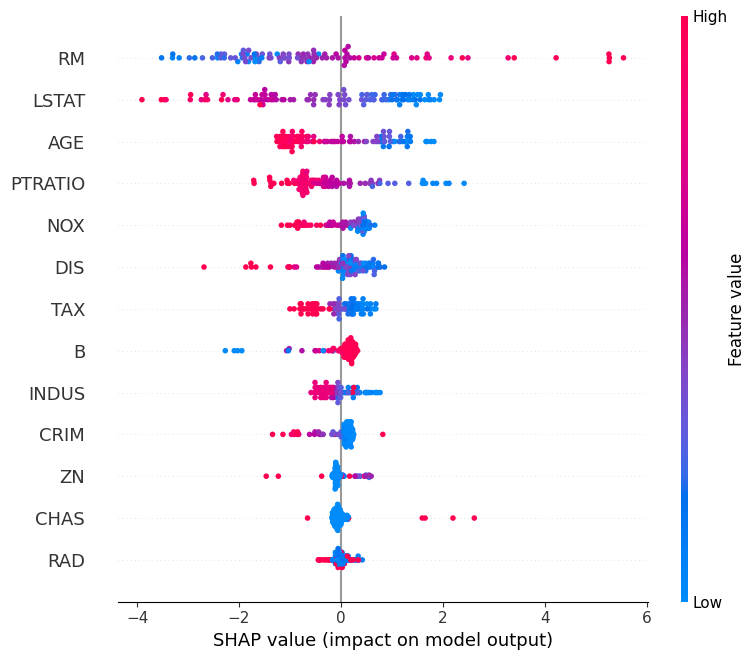

In [10]:
#------SHAP------
# --- Step 1: Setup ---
target_column = 'MEDV'

# Separate features and target
X = df.drop(columns=[target_column])
y = df[target_column]

# Optional: Save feature names for SHAP plot
feature_names = X.columns.tolist()

# --- Step 2: Preprocessing ---
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- Step 3: Train SVR ---
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale')
svr_model.fit(X_train, y_train)

# --- Step 4: SHAP Analysis ---
# Use SHAP KernelExplainer for non-tree models like SVR
explainer = shap.Explainer(svr_model.predict, X_train)
shap_values = explainer(X_test)

# --- Step 5: Plot ---
shap.summary_plot(shap_values, features=X_test, feature_names=feature_names)


In [11]:
# Get mean absolute SHAP values per feature
importances = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Keep top 75% most important features / gunakan 75 persen teratas
top_features = feature_importance.head(int(len(feature_importance) * 0.75)).index.tolist()

X_selected = df[top_features]



In [12]:
X_selected

,RM,LSTAT,AGE,PTRATIO,NOX,DIS,TAX,B,INDUS
0,6.575,4.980,65.2,15.3,0.538,4.0900,296.0,396.90,2.31
1,6.421,9.140,78.9,17.8,0.469,4.9671,242.0,396.90,7.07
2,7.185,4.030,61.1,17.8,0.469,4.9671,242.0,392.83,7.07
3,6.998,2.940,45.8,18.7,0.458,6.0622,222.0,394.63,2.18
4,7.147,4.527,54.2,18.7,0.458,6.0622,222.0,396.90,2.18
...,...,...,...,...,...,...,...,...,...
501,6.593,8.496,69.1,21.0,0.573,2.4786,273.0,391.99,11.93
502,6.120,9.080,76.7,21.0,0.573,2.2875,273.0,396.90,11.93
503,6.976,5.640,91.0,21.0,0.573,2.1675,273.0,396.90,11.93
504,6.794,6.480,89.3,21.0,0.573,2.3889,273.0,393.45,11.93


***Export to csv***

In [13]:
X_selected.to_csv("X_selected.csv", index=False)
df['MEDV'].to_csv("y.csv", index=False)